## Main task
* Classify images according to whether given cell image represents a cancerous cells or not (isCancerous).

## 1. Setup notebook

In [ ]:
# !pip install tensorflow
# !pip install keras
# !pip install opencv-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/ColabNotebooks/COSC2753/patch_images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: patch_images/5088.png   
  inflating: patch_images/5089.png   
  inflating: patch_images/509.png    
  inflating: patch_images/5090.png   
  inflating: patch_images/5091.png   
  inflating: patch_images/5092.png   
  inflating: patch_images/5093.png   
  inflating: patch_images/5094.png   
  inflating: patch_images/5095.png   
  inflating: patch_images/5096.png   
  inflating: patch_images/5097.png   
  inflating: patch_images/5098.png   
  inflating: patch_images/5099.png   
  inflating: patch_images/51.png     
  inflating: patch_images/510.png    
  inflating: patch_images/5100.png   
  inflating: patch_images/5101.png   
  inflating: patch_images/5102.png   
  inflating: patch_images/5103.png   
  inflating: patch_images/5104.png   
  inflating: patch_images/5105.png   
  inflating: patch_images/5106.png   
  inflating: patch_images/5107.png   
  inflating: patch_images/5108.png   
  inflating: patch_images/5116.png   

In [4]:
PATH = "/content/patch_images"

## 2. Data inspecting


### 2.1. Load csv files

In [5]:
%cd "/content/drive/MyDrive/ColabNotebooks/COSC2753/"

main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

/content/drive/MyDrive/ColabNotebooks/COSC2753


In [6]:
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [7]:
main_data.shape

(9896, 6)

In [8]:
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [9]:
extra_data.shape

(10384, 4)

### EDA on dataset: Please see on Notebook - Task 2

## 3. Data preparation

### 3.1. Split data into train and validation (test) set

In [10]:
from sklearn.model_selection import train_test_split

# Split data into raw train and validation set
# Task 1: Predict isCancerous
raw_train_task, val_task = train_test_split(main_data[['ImageName', 'isCancerous']], 
                                              test_size=0.3, 
                                              random_state=99)

In [11]:
# Sort the label for easier sampling
raw_train_task = raw_train_task.sort_values(by=['isCancerous']).reset_index(drop = True)
train_X = raw_train_task['ImageName']
train_Y = raw_train_task['isCancerous']

test_X = val_task['ImageName']
test_Y = val_task['isCancerous']

### 3.2. Create sample image to balance among classes

In [12]:
train_Y.value_counts()

0    4067
1    2860
Name: isCancerous, dtype: int64

In [13]:
from random import randint, choice

# Type of interpolation method in OpenCV
INTERPOLATION = [cv2.INTER_AREA, cv2.INTER_CUBIC, cv2.INTER_LINEAR, cv2.INTER_NEAREST]

def create_train_data(directory, img_list, label):
    # Map the index (0,1) to its value_counts
    item_order = label.value_counts().index.tolist()
    freq_order = label.value_counts().tolist()

    count_list = [element for _, element in sorted(zip(item_order, freq_order))]# List of value_counts in isCancerous

    # Create an array contains range for sampling
    sum_range = count_list.copy()
    for i in range(1, len(sum_range)):
        sum_range[i] += sum_range[i - 1]

    sum_range.insert(0, 0)

    # Get the counts from the majourity class
    MAX = max(count_list)
    
    train_data = []

    # Add original data 
    for name in tqdm(img_list, desc="Adding original images"):
        img_path = os.path.join(directory, name)  # Join the path together
        img = cv2.resize(cv2.imread(img_path), (27, 27))  # Transform it into np.array for image
        train_data.append(np.array(img))  # Add to train data

    # Add sample data
    for i in tqdm(range(MAX - count_list[1]), desc="Sampling class 1"):
        img_path = os.path.join(directory, choice(img_list[sum_range[1]:]))
        img = cv2.resize(cv2.imread(img_path), (27, 27), interpolation=INTERPOLATION[randint(0, 3)])  # Apply interpolation 
        train_data.append(np.array(img))

    print("\nSuccessfully sample images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [14]:
def create_test_data(directory, img_list):
    test_data = []
    for name in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(path), (27, 27))
        test_data.append(np.array(img))
    print("\nSuccessfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(test_data).astype('float32') / 255.0 

### 3.3. Create image array

In [15]:
train_X_img = create_train_data(PATH, train_X.to_list(), train_Y)

train_X_img.shape

Sampling class 1: 100%|██████████| 1207/1207 [00:00<00:00, 8116.83it/s]



Successfully sample images!


(8134, 27, 27, 3)

In [16]:
test_X_img = create_test_data(PATH, test_X.to_list())
test_X_img.shape

Extracting Image Progress: 100%|██████████| 2969/2969 [00:00<00:00, 11560.45it/s]


Successfully import images!


(2969, 27, 27, 3)

In [17]:
def resampling_label(label):  # Map the label to the new sample image
    item_order = label.value_counts().index.tolist()
    freq_order = label.value_counts().tolist()

    label_modify = label.values
    count_list = [element for _, element in sorted(zip(item_order, freq_order))] # List of value_counts in cellType

    MAX = max(count_list)
    for i in range(2):
        label_modify = np.concatenate((label_modify, np.full((MAX - count_list[i],), i, dtype=int)))

    return label_modify

train_Y_mod = resampling_label(train_Y)
train_Y_mod.shape

(8134,)

In [19]:
# Create datagen
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True)

train_datagen = datagen.flow(train_X_img, train_Y_mod, batch_size=16, shuffle=True)

## 4. Constructing CNN network

### 4.1. Model for task 1: isCancerous

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

model_isCancerous = Sequential()  # Initiate the model

# First convolutional layer(s)
model_isCancerous.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(MaxPooling2D((2, 2)))
model_isCancerous.add(Dropout(0.2))

# Second convolutional layer(s)
model_isCancerous.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(MaxPooling2D((2, 2)))
model_isCancerous.add(Dropout(0.2))

# Third convolutional layer(s)
model_isCancerous.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), padding='same'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(MaxPooling2D((2, 2)))
model_isCancerous.add(Dropout(0.2))

# Fully connected layer(s)
model_isCancerous.add(Flatten())
model_isCancerous.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), activation='relu'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Dropout(0.2))
model_isCancerous.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01), activation='relu'))
model_isCancerous.add(BatchNormalization())
model_isCancerous.add(Dropout(0.2))
model_isCancerous.add(Dense(1, activation='sigmoid')) # Output is 0 and 1

model_isCancerous.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)       

### 4.2. Compile and training

The best model has been trained and save to "Task1_Main.h5"

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr = 0.0001)

model_isCancerous.compile(optimizer=opt , loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15) 

EPOCHS = 500
BATCH_SIZE = 32

In [ ]:
import time
start_time = time.time()
history = model_isCancerous.fit(train_datagen, 
                                  validation_data=(test_X_img, test_Y), 
                                  batch_size=BATCH_SIZE, 
                                  epochs=EPOCHS, 
                                  verbose=1,
                                  callbacks=[reduce_lr, early])

print("---  Training cellType model in seconds ---%s " % (time.time() - start_time))

Epoch 1/500
509/509 [==============================] - 7s 12ms/step - loss: 13.0994 - accuracy: 0.6742 - val_loss: 11.9308 - val_accuracy: 0.7854
Epoch 2/500
509/509 [==============================] - 6s 11ms/step - loss: 11.5080 - accuracy: 0.8305 - val_loss: 10.4761 - val_accuracy: 0.8565
Epoch 3/500
509/509 [==============================] - 6s 11ms/step - loss: 10.1916 - accuracy: 0.8478 - val_loss: 9.2966 - val_accuracy: 0.8518
Epoch 4/500
509/509 [==============================] - 6s 12ms/step - loss: 8.9912 - accuracy: 0.8509 - val_loss: 8.1646 - val_accuracy: 0.8633
Epoch 5/500
509/509 [==============================] - 6s 12ms/step - loss: 7.8973 - accuracy: 0.8675 - val_loss: 7.1950 - val_accuracy: 0.8323
Epoch 6/500
509/509 [==============================] - 6s 12ms/step - loss: 6.9200 - accuracy: 0.8545 - val_loss: 6.2464 - val_accuracy: 0.8488
Epoch 7/500
509/509 [==============================] - 6s 11ms/step - loss: 5.9954 - accuracy: 0.8622 - val_loss: 5.4370 - val_accu

### 4.3. Save model and plot accuracy

In [34]:
from datetime import datetime
dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
export = 'Task1_Main_{ft}.h5'.format(ft=dt_string)
print(export)

model_isCancerous.save(export)

Task1_24-05-2021_13-37-15.h5


In [35]:
scores_isCancerous = model_isCancerous.evaluate(test_X_img, test_Y, verbose=1)
print('Validation loss:', scores_isCancerous[0])
print('Validation accuracy:', scores_isCancerous[1])
print('Max Validation accuracy:', max(history.history['val_accuracy']))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

best_main = load_model('Task1_Main.h5') 

pred = best_main.predict_classes(test_X_img)
pred = pred.reshape(1,-1)[0]

print(classification_report(test_Y, pred, target_names=['Class 0','Class 1']))

              precision    recall  f1-score   support

     Class 0       0.95      0.93      0.94      1750
     Class 1       0.91      0.93      0.92      1219

    accuracy                           0.93      2969
   macro avg       0.93      0.93      0.93      2969
weighted avg       0.93      0.93      0.93      2969



## 5. Utilizing extraData

The more data fit into deep learning, the higher the performace. We will try to investigating this assumption by merging mainData and extraData together

### 5.1. Merge into raw_train

In [21]:
raw_train_task

,ImageName,isCancerous
0,16845.png,0
1,1109.png,0
2,7744.png,0
3,9985.png,0
4,16448.png,0
...,...,...
6922,14057.png,1
6923,4323.png,1
6924,4330.png,1
6925,5615.png,1


In [22]:
tmp = [raw_train_task, extra_data[['ImageName','isCancerous']]]
raw_train = pd.concat(tmp)
raw_train

,ImageName,isCancerous
0,16845.png,0
1,1109.png,0
2,7744.png,0
3,9985.png,0
4,16448.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


### 5.2. Split into images and labels

In [23]:
raw_train = raw_train.sort_values(by=['isCancerous']).reset_index(drop = True)
train_X_merge = raw_train['ImageName']
train_Y_merge = raw_train['isCancerous']

In [24]:
print(train_Y_merge.value_counts())

0    11461
1     5850
Name: isCancerous, dtype: int64


In [25]:
train_X_merge_img = create_train_data(PATH, train_X_merge.to_list(), train_Y_merge)

train_X_merge_img.shape

Sampling class 1: 100%|██████████| 5611/5611 [00:00<00:00, 6813.91it/s]



Successfully sample images!


(22922, 27, 27, 3)

In [26]:
train_Y_merge_mod = resampling_label(train_Y_merge)

train_Y_merge_mod.shape

(22922,)

In [39]:
dtg = ImageDataGenerator()

merge_datagen = dtg.flow(train_X_merge_img, train_Y_merge_mod, batch_size=16, shuffle=True)

### 5.2. Compile model 

In [44]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr = 0.001)

model_isCancerous.compile(optimizer=opt , loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
import time
start_time = time.time()
history = model_isCancerous.fit(merge_datagen, 
                                  validation_data=(test_X_img, test_Y), 
                                  batch_size=64, 
                                  epochs=EPOCHS, 
                                  verbose=1,
                                  callbacks=[reduce_lr, early])

print("---  Training cellType model in seconds ---%s " % (time.time() - start_time))

Epoch 1/500
1433/1433 [==============================] - 24s 15ms/step - loss: 7.0359 - accuracy: 0.8220 - val_loss: 0.8552 - val_accuracy: 0.7663
Epoch 2/500
1433/1433 [==============================] - 20s 14ms/step - loss: 0.4964 - accuracy: 0.8498 - val_loss: 0.5094 - val_accuracy: 0.8292
Epoch 3/500
1433/1433 [==============================] - 20s 14ms/step - loss: 0.4633 - accuracy: 0.8490 - val_loss: 5.7630 - val_accuracy: 0.6211
Epoch 4/500
1433/1433 [==============================] - 19s 14ms/step - loss: 0.4622 - accuracy: 0.8431 - val_loss: 0.4272 - val_accuracy: 0.8798
Epoch 5/500
1433/1433 [==============================] - 19s 13ms/step - loss: 0.4562 - accuracy: 0.8528 - val_loss: 0.4529 - val_accuracy: 0.8404
Epoch 6/500
1433/1433 [==============================] - 19s 13ms/step - loss: 0.4491 - accuracy: 0.8554 - val_loss: 1.3184 - val_accuracy: 0.6477
Epoch 7/500
1433/1433 [==============================] - 18s 13ms/step - loss: 0.4446 - accuracy: 0.8510 - val_loss: 0

In [48]:
dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
export = 'Task1_Extra_{ft}.h5'.format(ft=dt_string)
print(export)

model_isCancerous.save(export)

Task1_Extra_24-05-2021_14-16-06.h5


93/93 [==============================] - 1s 7ms/step - loss: 0.2476 - accuracy: 0.9084
Validation loss: 0.24760138988494873
Validation accuracy: 0.9083866477012634
Max Validation accuracy: 0.9131020307540894


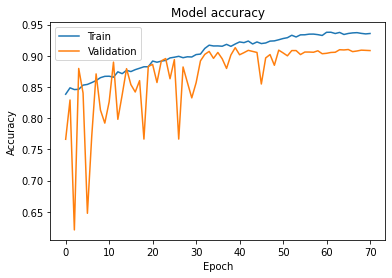

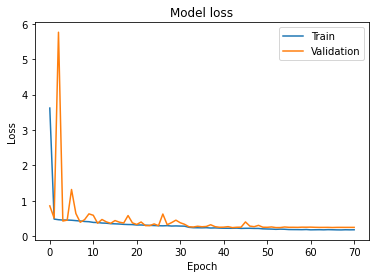

In [46]:
scores_isCancerous = model_isCancerous.evaluate(test_X_img, test_Y, verbose=1)
print('Validation loss:', scores_isCancerous[0])
print('Validation accuracy:', scores_isCancerous[1])
print('Max Validation accuracy:', max(history.history['val_accuracy']))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [47]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

pred = model_isCancerous.predict_classes(test_X_img)
pred = pred.reshape(1,-1)[0]

print(classification_report(test_Y, pred, target_names=['Class 0','Class 1']))

              precision    recall  f1-score   support

     Class 0       0.92      0.93      0.92      1750
     Class 1       0.89      0.88      0.89      1219

    accuracy                           0.91      2969
   macro avg       0.91      0.90      0.91      2969
weighted avg       0.91      0.91      0.91      2969

